In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim 
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from tqdm import tqdm
import time 

import dataloading
import data_vis

c:\Users\Aneesh\anaconda3\envs\vision_models\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(2346)

In [3]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [4]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

train_dataset, val_dataset, test_dataset = dataloading.get_datasets(train, val, test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [5]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#Creating a new model class that is essentially just the ViT model minus the classification head. This will get us our features.
class ViTEmbeddingNet(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, pixel_values: torch.FloatTensor,labels: torch.LongTensor = None):
        outputs = self.vit(pixel_values)
        # Use [CLS] token (first token in the sequence) as embedding
        return outputs.last_hidden_state[:, 0]

In [7]:
#Instatiating encoder and loading it to chosen device
encoder = ViTEmbeddingNet(vit)

encoder.to(device) 

ViTEmbeddingNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_f

In [8]:
#Defining optimizer, loss function, and what kind of mining to use for triplets
optimizer = optim.Adam(encoder.parameters(), lr=2e-5)  # Smaller LR for pretrained models
loss_func = TripletMarginLoss(margin=0.19)
miner = TripletMarginMiner(margin=0.19, type_of_triplets="semihard")

In [9]:
#This is where we would train the model (it's commented out because it takes about ~1.5 hours to run each time), just loading the weights here instead

"""losses = []
num_epochs = 10
for j in range(num_epochs):
    for i, batch in enumerate(tqdm(train_dataloader)):

        images = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        embeddings = encoder(images)

        # Use miner to find triplets from labels + embeddings
        mined_triplets = miner(embeddings, labels)

        # Pass embeddings, labels, and mined triplets
        loss = loss_func(embeddings, labels, mined_triplets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())"""

"losses = []\nnum_epochs = 10\nfor j in range(num_epochs):\n    for i, batch in enumerate(tqdm(train_dataloader)):\n\n        images = batch['pixel_values'].to(device)\n        labels = batch['labels'].to(device)\n\n        embeddings = encoder(images)\n\n        # Use miner to find triplets from labels + embeddings\n        mined_triplets = miner(embeddings, labels)\n\n        # Pass embeddings, labels, and mined triplets\n        loss = loss_func(embeddings, labels, mined_triplets)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        losses.append(loss.item())"

In [10]:
#torch.save(encoder.state_dict(), 'model_weights_camera_10-27-25.pth')

In [11]:
encoder.load_state_dict(torch.load('weights/model_weights_camera_10-27-25.pth', weights_only=True))
encoder.eval()

ViTEmbeddingNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_f

In [13]:
#Get embeddings of the first batch of data
batch = next(iter(val_dataloader))

images = batch['pixel_values'].to(device)
labels = batch['labels']

embedding = encoder(images)

In [14]:
#Use PCA to reduce data to two dimensions so that we can visualize them 
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)

reduced_embedding = pca_model.fit_transform(embedding.to("cpu").detach().numpy())

In [15]:
labels_np = labels.detach().numpy()

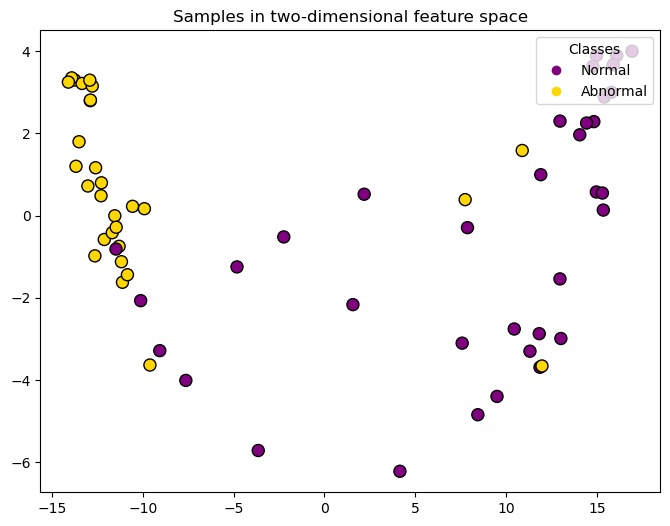

In [16]:
data_vis.plot_data(reduced_embedding, labels_np)

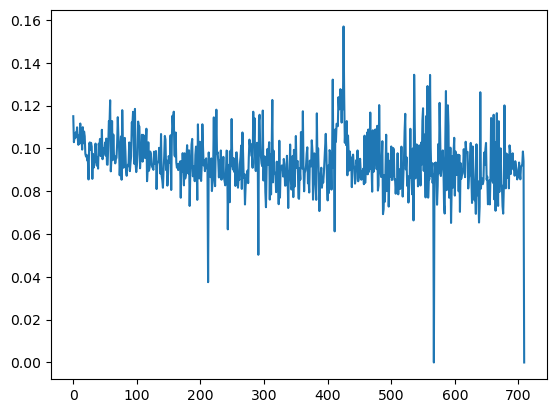

In [ ]:
import matplotlib.pyplot as plt

#plt.plot(list(range(len(losses))), losses)